# Overview
***
This dataset contains all transactions of a UK-based online retail shop. Many of the shop's customers are wholesalers. We will start with checking for any missing values and for inconsistencies in the data. 

## Objective
- The purpose of this notebook is to show three different ways that a company could segment their customers.
- In this notebook we will also identify who are our best customers, which countries are generating most of our sales, and which items sell the most. 
- The three techniques we will use to segment our customers are "Customer Lifetime Value, "RFM Analysis", and "Kmeans clustering".

## Project Workflow
The notebook will be split into 5 parts
1. Data Cleaning
2. Exploratory Data Analysis
3. Customer Lifetime Value
4. RFM Analysis
5. K-Means Clustering

## Column info
- InVoice: Transaction code. Unique 6 digit number. "C" at the start equals cancellation.
- Stock Code: Product code. Nominal, a unique 5 digit number.
- Description: Product name.
- Quantity: The quantities of each product per transaction.
- InvoiceDate: Invoice date and time (when transaction was generated).
- UnitPrice: Product price per unit in sterling.
- CustomerID: Unique 5 digit number assigned to customers.
- Country: The name of the country where each customer resides.
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import re
import datetime as dt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import dash
df = pd.read_csv("data/e-commerce.csv", encoding="unicode_escape")

### 1. Data Cleaning

In [2]:
print(df.head(5))
print("\n")
print(df.info())
print("\n")
print(df.isna().sum())
print("\n")
print(df.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo 

- It appears that we have several missing values for the "Description"(1454) and "CustomerID"(135080) columns. Maybe we should explore them for further details.
- Also, we see that the minimum values for Quantity and UnitPrice are large negative numbers which warrants an investigation into why.

In [3]:
pct_na = df[df["CustomerID"].isna()].shape[0]
df_shape = df.shape[0]
pct_na/df_shape

df[df["Description"].isna()].head(30)
not_guests = df.copy()
not_guests = not_guests[not_guests["CustomerID"].notna()]
not_guests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


- It appears that about 25% of the "CustomerID's" have missing values. Since our purpose is to identify specific customers we made a copy of the first dataframe that removes the customers that do not have any ID's.
- We now have a dataframe with no null values with about 406,829 rows.
- We know from the dataset description that some orders are cancelled orders. Let's check on those to see if we notice anything.

In [4]:
cancelled_not_guests = not_guests[not_guests["InvoiceNo"].str.startswith("C")]
cancelled_df = df[df["InvoiceNo"].str.startswith("C")]
pct1 = round(((cancelled_df.shape[0]/df.shape[0])*100), 2)
pct2 = round(((cancelled_not_guests.shape[0] / not_guests.shape[0])*100), 2)
print(f"Cancelled orders PCT in original df: {pct1}%")
print(f"Cancelled orders PCT in not_guests dataframe: {pct2}%")

Cancelled orders PCT in original df: 1.71%
Cancelled orders PCT in not_guests dataframe: 2.19%


- We find that "cancelled" orders only make up about 1.71% in the original dataframe, while they make up about 2.19% in the "not_guests" dataframe we created.
- We find something peculiar, we see that this dataset has discounts present in it with a stock code of "D" something that was not mentioned in the dataset description. Also, there is something labeled as "Manuel".
- We also see that a cancelled order does not necessarily mean that the order was completely cancelled.
- It appears some cancelled orders have special stock codes representing different things. Let's see if we can track down all unique ones.

In [5]:
special_df = df[df.StockCode.str.contains("^[a-zA-Z]+", regex=True)]
special_stock = cancelled_not_guests[cancelled_not_guests.StockCode.str.contains("^[a-zA-Z]+", regex=True)]
print(special_df["StockCode"].value_counts())
print(special_stock["StockCode"].value_counts())

POST            1256
DOT              710
M                571
C2               144
D                 77
S                 63
BANK CHARGES      37
AMAZONFEE         34
CRUK              16
DCGSSGIRL         13
DCGSSBOY          11
gift_0001_20      10
gift_0001_10       9
gift_0001_30       8
DCGS0003           5
gift_0001_50       4
PADS               4
gift_0001_40       3
B                  3
DCGS0069           2
DCGS0076           2
DCGS0070           2
DCGS0074           1
DCGS0066P          1
DCGS0072           1
DCGS0057           1
DCGS0071           1
DCGS0067           1
DCGS0068           1
m                  1
DCGS0004           1
DCGS0055           1
DCGS0073           1
Name: StockCode, dtype: int64
M       175
POST     97
D        77
CRUK     16
C2        1
Name: StockCode, dtype: int64


- It seems that the original dataframe was littered with special stock codes ranging from discounts, gift vouchers, bank charges, Amazon fee's, etc. With no customer ID's to tie the special stock codes to any customer. Let's move on with the dataframe that we made with no missing customer ID's.

### 2. Exploratory Data Analysis

In [6]:
cleaned_df = not_guests.copy()
cleaned_df = cleaned_df[~cleaned_df["InvoiceNo"].str.startswith("C")]

In [7]:
cleaned_df["InvoiceDate"] = pd.to_datetime(cleaned_df["InvoiceDate"])
cleaned_df["Revenue"] = cleaned_df["Quantity"] * cleaned_df["UnitPrice"]

           Country       Revenue  Percentage Total Sales
35  United Kingdom  7.308392e+06                0.880818
23     Netherlands  2.854463e+05                0.034402
10            EIRE  2.655459e+05                0.032004
14         Germany  2.288671e+05                0.027583
13          France  2.090240e+05                0.025192


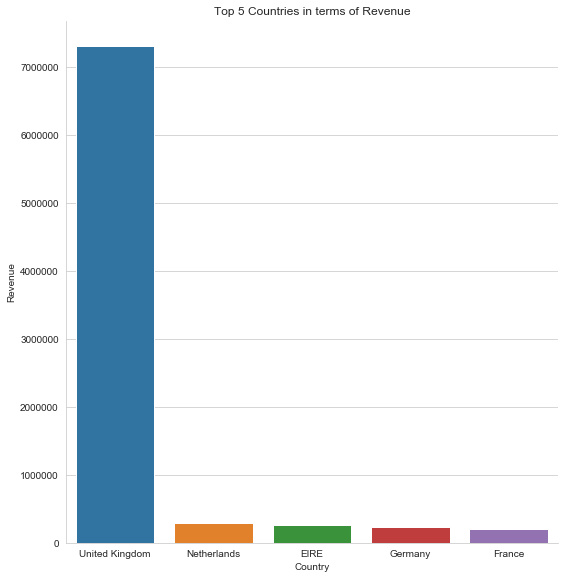

In [8]:
revenue_countries = cleaned_df.groupby("Country", as_index=False)["Revenue"].sum().sort_values("Revenue", ascending=False).head(5)
revenue_countries["Percentage Total Sales"] = revenue_countries["Revenue"] / revenue_countries["Revenue"].sum() 
print(revenue_countries.sort_values(by="Percentage Total Sales", ascending=False))
sns.catplot(data=revenue_countries, kind="bar", x="Country", y="Revenue", height=8);
plt.title("Top 5 Countries in terms of Revenue");

- It's no surprise that the United Kingdom is the top country in revenue generated. This wholesaler is based in the U.K!
- However, the size of revenue percentage is a little jarring, the U.K makes up about 88% of all revenue! 

              InvoiceDate    Revenue
17256 2011-12-09 09:15:00  168469.60
1778  2011-01-18 10:01:00   77183.60
7469  2011-06-10 15:28:00   39597.40
11689 2011-09-20 11:05:00   31698.16
7644  2011-06-15 13:37:00   23426.81


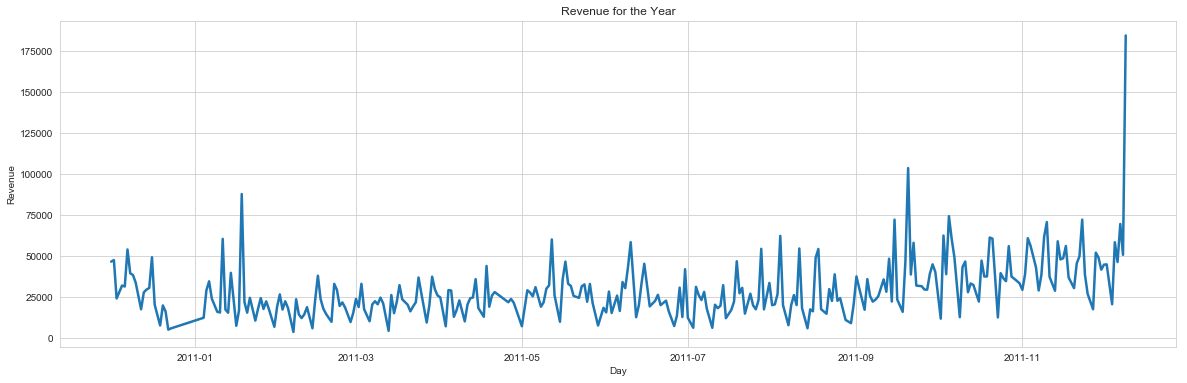

In [9]:
revenue_month = cleaned_df.copy()
revenue_month["Day"] = [d.date() for d in revenue_month["InvoiceDate"]]
xy = revenue_month.groupby("Day", as_index=False)["Revenue"].sum()
xy.head()
plt.figure(figsize=(20, 6));
sns.lineplot(data=xy, x="Day", y="Revenue", palette="tab10", linewidth=2.5);
plt.title("Revenue for the Year");
print(cleaned_df.groupby("InvoiceDate", as_index=False)["Revenue"].sum().sort_values("Revenue", ascending=False).head())

- Remarkably it shows that the peak revenue months are during the beginning of the year and the end of the year. With the peak at the end of the year being twice the peak at the beginning of the year.

                             Description    Revenue  PCT of Revenue
2319         PAPER CRAFT , LITTLE BIRDIE  168469.60            1.92
2767            REGENCY CAKESTAND 3 TIER  142592.95            1.62
3698  WHITE HANGING HEART T-LIGHT HOLDER  100448.15            1.14
1762             JUMBO BAG RED RETROSPOT   85220.78            0.97
1992      MEDIUM CERAMIC TOP STORAGE JAR   81416.73            0.93
2345                       PARTY BUNTING   68844.33            0.78
216        ASSORTED COLOUR BIRD ORNAMENT   56580.34            0.64
2656                  RABBIT NIGHT LIGHT   51346.20            0.58
722                        CHILLI LIGHTS   46286.51            0.53
2313     PAPER CHAIN KIT 50'S CHRISTMAS    42660.83            0.49


The top 10 items make up 9.5% of sales!




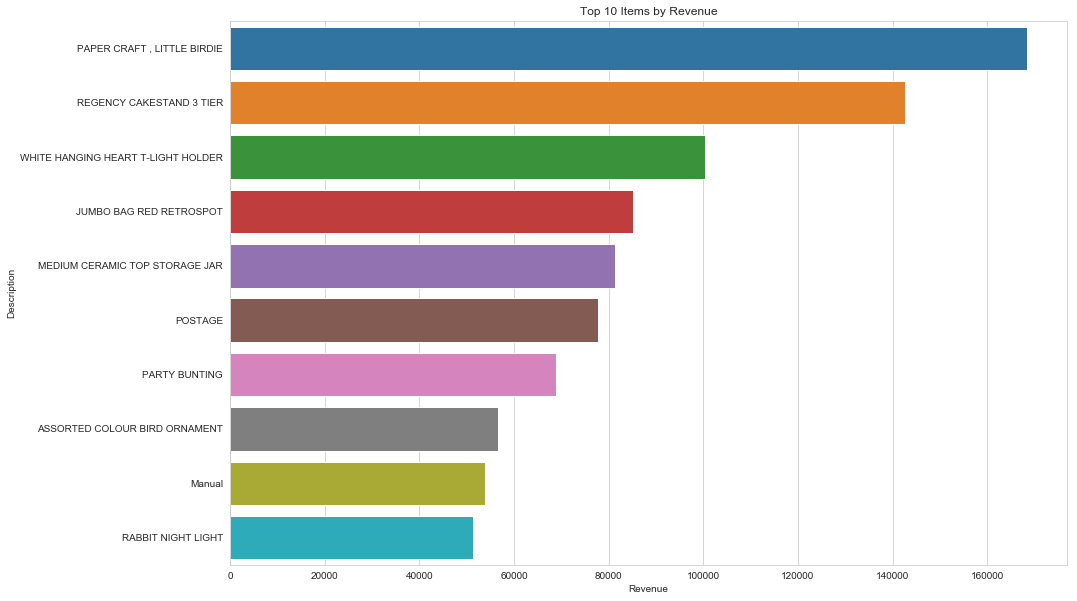

In [10]:
top_items = cleaned_df.copy()
top_items = top_items.groupby("Description", as_index=False)["Revenue"].sum().sort_values("Revenue", ascending=False)
top_items_graph = top_items.head(10)
top_items.drop([2611, 2130], inplace=True)
top_items["PCT of Revenue"] = round((top_items["Revenue"]/top_items["Revenue"].sum())*100, 2)

plt.figure(figsize=(15,10));
sns.barplot(x="Revenue", y="Description", data=top_items_graph, orient="h");
plt.title("Top 10 Items by Revenue")
print(top_items.head(10))
print("\n")
print(f"The top 10 items make up 9.5% of sales!" )
print("\n")

- The companies' revenue appears to be well diversified among various items. There are no real big hitter items that make up a majority of the companies' sales. For example, the top revenue generating item is a "Little Birdie" papercraft but even that only makes up about 1.92% of all sales. All in all the top 10 items make up only 9.5% of all revenue.

### 3. Customer LifeTime Value
- We will now calculate the customer lifetime value of every customer. The formula we will use to calcualte this is ((Average Order Value * Purchase Frequency)/Churn Rate) * profit margin. 
- Customer Lifetime Value (CLTV) tells companies how much revenue they can expect one customer to generate over the course of the business relationship. The longer a customer continues to purchase from a company, the greater their lifetime value becomes.

In [11]:
cltv = cleaned_df.copy()
cltv = cltv.groupby("CustomerID").agg({"InvoiceDate": lambda date: (date.max()-date.min()).days,
                                      "InvoiceNo": lambda num: len(num),
                                      "Quantity": lambda quant: quant.sum(),
                                      "Revenue": lambda price: price.sum()})

cltv["AVG_order_value"] = cltv["Revenue"]/cltv["InvoiceNo"]
purchase_freq = cltv["InvoiceNo"].sum()/cltv.shape[0]
x = cltv[cltv["InvoiceNo"] > 1].shape[0] / cltv.shape[0]
churn = 1-x
# since this is a wholesaler the margins should be slightly higher
cltv["Profit_margin"] = cltv["Revenue"]*0.08
cltv["LTV"] = (cltv["AVG_order_value"] * purchase_freq)/churn
cltv["CLTV"] = cltv["LTV"] * cltv["Profit_margin"]
cltv.sort_values("CLTV", ascending= False).head(10)

,InvoiceDate,InvoiceNo,Quantity,Revenue,AVG_order_value,Profit_margin,LTV,CLTV
CustomerID,,,,,,,,
16446.0,204,3,80997,168472.50,56157.500000,13477.8000,3.103669e+08,4.183063e+12
12346.0,0,1,74215,77183.60,77183.600000,6174.6880,4.265723e+08,2.633951e+12
15098.0,0,3,121,39916.50,13305.500000,3193.3200,7.353580e+07,2.348233e+11
15749.0,97,10,18028,44534.30,4453.430000,3562.7440,2.461287e+07,8.768936e+10
18102.0,366,431,64124,259657.30,602.453132,20772.5840,3.329591e+06,6.916421e+10
17450.0,359,337,69993,194550.79,577.302047,15564.0632,3.190588e+06,4.965851e+10
17949.0,370,70,30546,58510.48,835.864000,4680.8384,4.619588e+06,2.162355e+10
14646.0,353,2080,197491,280206.02,134.714433,22416.4816,7.445292e+05,1.668973e+10
16029.0,335,242,40208,81024.84,334.813388,6481.9872,1.850421e+06,1.199440e+10


- We have now customer lifetime values for all customers allowing us to identify which customers will be the most profitable in the long run.
- The above table also shows each customers total quantity ordered, the total revenue generated, average order value, and their profit margin.

### 4. RFM Analysis
- Another way we can segment customers is through the use of RFM analysis. RFM stands for recency, frequency. and monetary. Recency is the time since the customer last ordered. Frequency is the average time between customer orders. Monetary is average transaction value. The idea is recency represents the freshness of the customer transaction. The more frequently a customer buys the more satisfied they are with your business. While monetary helps differentiate heavy spenders from low spenders.
- Users are then ranked by percentile with top 20% getting a score of 5, next 20% getting a score of 4 and so on. We can then add these scores together to determine how good of a customer they are. 

In [12]:
rfm = cleaned_df.copy()
t = dt.datetime(2012,1,1)
r = rfm.groupby("CustomerID").agg({"Revenue": lambda x:x.sum(), "InvoiceDate": lambda x:(t-x.max()).days})
f = rfm.groupby(["CustomerID", "InvoiceNo"]).agg({"Revenue": lambda x:x.sum()})
m = rfm.groupby("CustomerID").agg({"Revenue": lambda x:len(x)})
rfm_analysis = pd.merge(r,m, on="CustomerID")
rfm_analysis.rename(columns={"InvoiceDate":"R", "Revenue_y":"F", "Revenue_x":"M"}, inplace=True)
rfm_analysis.head()

,M,R,F
CustomerID,,,
12346.0,77183.60,347,1.0
12347.0,4310.00,24,182.0
12348.0,1797.24,97,31.0
12349.0,1757.55,40,73.0
12350.0,334.40,332,17.0


In [13]:
quant = rfm_analysis.quantile(q=[0.20, 0.40, 0.60, 0.80])
quant = quant.to_dict()
table = rfm_analysis.copy()

def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5
            
table["F_Quant"] = table["F"].apply(RScore, args=("F", quant))
table = table.sort_values("R", ascending=True)
table["R_Quant"] = pd.qcut(table["R"], 5, labels=False)
table["M_Quant"] = pd.qcut(table["M"], 5, labels=False)
rfm_analysis["RFM_Score"] = table["R_Quant"].map(str) + table["F_Quant"].map(str) + table["M_Quant"].map(str)
rfm_analysis["Score_Sum"] = table["R_Quant"] + table["F_Quant"] + table["M_Quant"]

In [14]:
final = rfm_analysis[["R", "F", "M", "RFM_Score", "Score_Sum"]]
final.head()

,R,F,M,RFM_Score,Score_Sum
CustomerID,,,,,
12346.0,347,1.0,77183.60,414,9
12347.0,24,182.0,4310.00,054,9
12348.0,97,31.0,1797.24,333,9
12349.0,40,73.0,1757.55,143,8
12350.0,332,17.0,334.40,421,7


- We now have a credible score to classify our customers with. With a top score of 15 being a near perfect customer who purchases frequently and brings in the most revenue.

### 5. K-means customer segmentation
- The final customer segmentation technique is also the most computer intensive, it is a computer algorithm called K-means. Kmeans clustering is a clustering technique to divide data into different groups where the observations in each group are similar to one another. A goal of clustering is to identify significant and meaningful groups of data. The variables we will use to segment our customers will be our "RFM" columns that we made in our last section.

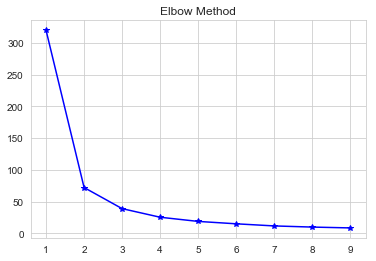

In [18]:
cluster_analysis = final[["R", "F", "M"]].copy()
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(cluster_analysis)
x = pd.DataFrame(scaled_x)

clusters = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=40)
    kmeans.fit(x)
    clusters.append(kmeans.inertia_)

plt.plot(range(1,10), clusters, marker="*", c="blue");
plt.title("Elbow Method");

In [19]:
kk = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300)
kk.fit(x)
pred = kk.predict(x)
score = silhouette_score(x, kk.labels_)
y_kmeans = kk.predict(x)
d = pd.DataFrame(cluster_analysis)
d["cluster"] = y_kmeans
d.groupby("cluster").mean()

,R,F,M
cluster,,,
0,105.823529,51.886210,1014.687408
1,215.018395,34.443144,721.201958
2,41.800634,141.265519,3237.989697
3,330.486922,23.637827,566.710322


- As you can see our algorithm has segmented our customers into 4 distinct clusters based on our "RFM" columns. If we had demographic data on our customers our clusters would be even more distinct. However, with the clusters we have now we have a pretty good idea on our customers spending habits. 
- For example, cluster 2 has the highest time between purchases but they end up generating a sizeable amount of revenue. 
- While cluster 3 hasnt bought anytime recently and when they do buy its frequent small purchases.